# Drilling Activity Prediction: Data Modeling - RNN

- Load datasets and resample to monthly frequency
- Use oil dataset to make predictions in oil rig count variable:
    - Tune Data: To adjust re-train models and check performances
    - ETS Decomposition: Identify Trend, Seasonality and Error
    - Train/test split
    - Scale and Transform data
    - TimeSeries Generator
    - Create RNN for OIL DF
    - EarlyStopping
    - Evaluation Batch
    - Inverse Transformed data
    - Plot Test Set Vs Predictions


- Create Model with Gas dataset to make predictions in Gas Rig Counts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import tensorflow
import datetime
from numpy.random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = 6,6

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)

### Tune Data

- freq_time: Index time frequency
- decimals: dataset decimals
- nobs: train/test split point. Also, it represents the number of final predictions to be generated.
- n_input: Length of the output sequences (in number of timesteps) The number of data points the model will use before making one prediction.
- n_features: Numer of features in the dataset (including dependent variable)
- Batch Size: Number of batches TimeseriesGenerator will produce. A single batch contains 'nobs' samples and 1x prediction.
- LSTM_neurons: Number of neurons for Long-short term memory unit
- activation_fct: Activation Function type for the neurons
- n_epochs: Number of epochs (number of full scans of NN)

In [3]:
# Dataset
freq_time = 'M'
decimals = 2
nobs = 12 #Number of Predictions

#timeseries generator

n_input = 12   #Minimum 12 based on Seasonality shown below
batchsize = 1

#RNN
LSTM_neurons = 20
activation_fct = 'relu'
n_features_oil = len(dfoil.columns)
n_features_gas = len(dfgas.columns)
n_epochs = 30


#
seed(1)
tensorflow.random.set_seed(1)

In [4]:
dfoil = dfoil.resample(freq_time).mean()
dfoil.index.freq = freq_time
dfoil = dfoil.round(decimals)

dfgas = dfgas.resample(freq_time).mean()
dfgas.index.freq = freq_time
dfgas = dfgas.round(decimals)

#### ETS Decomposition

With ETS Decomposition, we define the number of observations needed to get at least one cycle of seasonality. In that way, we use that as number of observations (n_input) so the RNN can understand seasonality.

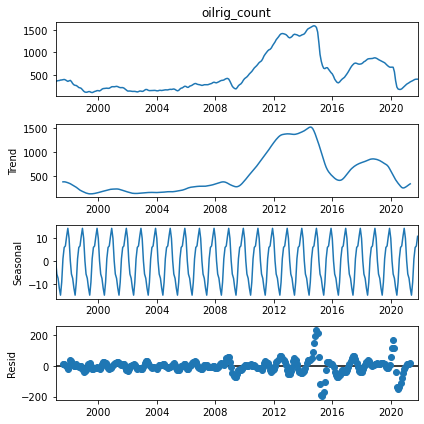

In [5]:
results = seasonal_decompose(dfoil['oilrig_count'])
results.plot();

<AxesSubplot:>

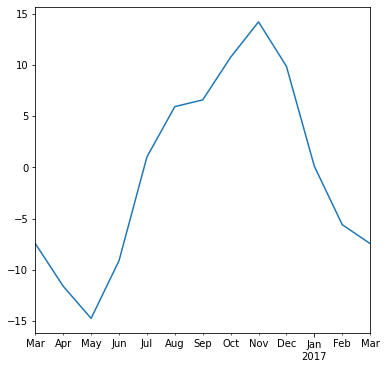

In [6]:
results.seasonal.loc['2016-03':'2017-03'].plot() #Minimum 12 for n_input!

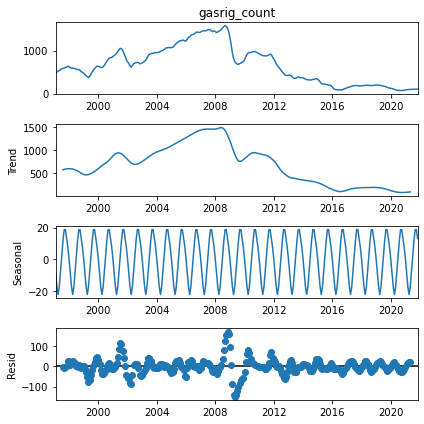

In [7]:
results = seasonal_decompose(dfgas['gasrig_count'])
results.plot();

#### Train/test split



In [8]:
train_oil = dfoil.iloc[:len(dfoil)-nobs]
test_oil = dfoil.iloc[len(dfoil)-nobs:]

train_gas = dfgas.iloc[:len(dfgas)-nobs]
test_gas = dfgas.iloc[len(dfgas)-nobs:]

#### Scale and Transform Data

In [9]:
scaler_oil = MinMaxScaler()
scaler_oil.fit(train_oil) #fit only in train set
train_oil_transformed = scaler_oil.transform(train_oil)
test_oil_transformed = scaler_oil.transform(test_oil)



scaler_gas = MinMaxScaler()
scaler_gas.fit(train_gas)
train_gas_transformed = scaler_gas.transform(train_gas)
test_gas_transformed = scaler_gas.transform(test_gas)

#### Early Stopping

In [10]:
earlystop = EarlyStopping(monitor='val_loss',patience=1)

#### Create Timeseries Generator

In [11]:
generator_oil = TimeseriesGenerator(data=train_oil_transformed,
                                          targets=train_oil_transformed,
                                          length = n_input,
                                          batch_size= batchsize
                                         )


generator_gas = TimeseriesGenerator(data=train_gas_transformed,
                                          targets=train_gas_transformed,
                                          length = n_input,
                                          batch_size= batchsize
                                         )

In [12]:
X,Y = generator_oil[0]

In [13]:
X.shape

(1, 12, 5)

In [14]:
Y

array([[0.18225237, 0.04411406, 0.55608398, 0.26622167, 0.12092069]])

#### Create RNN (Oil df)

In [15]:
model_oil = Sequential()
model_oil.add(LSTM(LSTM_neurons,activation=activation_fct,input_shape=(n_input,n_features_oil)))
model_oil.add(Dense(10,activation=activation_fct,input_shape=(n_input,n_features_oil)))
model_oil.add(Dense(n_features_oil))
model_oil.compile(optimizer='adam',loss='mse')
model_oil.fit_generator(generator_oil,epochs=n_epochs,validation_data=generator_oil,callbacks=[earlystop]) #early stop!

Epoch 1/30
274/274 [==============================] - 2s 5ms/step - loss: 0.1116 - val_loss: 0.0147
Epoch 2/30
274/274 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 3/30
274/274 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 4/30
274/274 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 5/30
274/274 [==============================] - 1s 5ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 6/30
274/274 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 0.0062


In [16]:
model_oil.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2080      
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 2,345
Trainable params: 2,345
Non-trainable params: 0
_________________________________________________________________


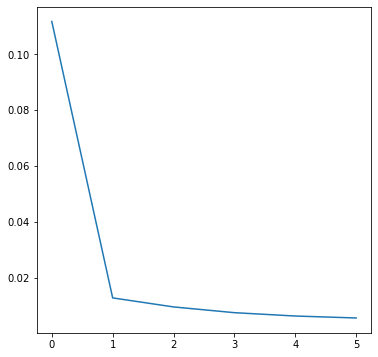

In [17]:
plt.plot(range(len(model_oil.history.history['loss'])),model_oil.history.history['loss'])

<AxesSubplot:>

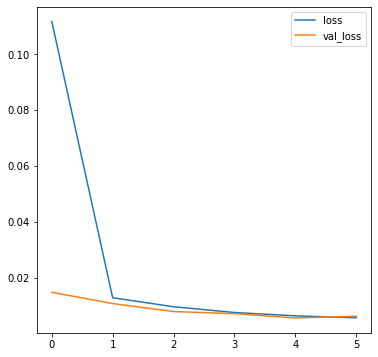

In [18]:
losses = pd.DataFrame(model_oil.history.history)
losses.plot()

#### Evaluation Batch

In [19]:
testoil_predictions = [] #store the predictions
evalbatch_oil = train_oil_transformed[-n_input:] #last observations (nobs) from the train set used to make the first prediction
print(f'Before Reshape:\n {evalbatch_oil}, \nShape: {evalbatch_oil.shape}')
evalbatch_oil = evalbatch_oil.reshape((1,n_input,n_features_oil)) #reshape this to what RNN wants.
print(f'\nAfter Reshape:\n {evalbatch_oil}, \nShape: {evalbatch_oil.shape}')

for i in range(nobs):
    one_pred = model_oil.predict(evalbatch_oil)[0] #Grab the numbers only, not the array
    testoil_predictions.append(one_pred)
    evalbatch_oil = np.append(evalbatch_oil[:,1:,:],[[one_pred]],axis=1)

Before Reshape:
 [[0.38136587 0.3717605  0.93574256 0.98019891 0.66462946]
 [0.37897446 0.39483305 0.82206241 0.98444399 0.63755035]
 [0.38056424 0.37858478 0.7666645  0.99675383 0.61372955]
 [0.37811894 0.3195223  0.80039806 1.         0.6477514 ]
 [0.31031068 0.14249736 0.71126517 0.99367804 0.69537279]
 [0.17713273 0.03802096 0.         0.91027093 0.81654632]
 [0.08299202 0.14265984 0.2131975  0.83040398 0.87542291]
 [0.05341938 0.22024535 0.43592928 0.76158627 0.91350826]
 [0.04722192 0.23893086 0.52132767 0.78303995 0.90573272]
 [0.04715456 0.25111707 0.53021833 0.72670803 0.83586161]
 [0.05568953 0.22845073 0.47119343 0.73562915 0.79335288]
 [0.07347354 0.22739459 0.59965173 0.73055221 0.76886517]], 
Shape: (12, 5)

After Reshape:
 [[[0.38136587 0.3717605  0.93574256 0.98019891 0.66462946]
  [0.37897446 0.39483305 0.82206241 0.98444399 0.63755035]
  [0.38056424 0.37858478 0.7666645  0.99675383 0.61372955]
  [0.37811894 0.3195223  0.80039806 1.         0.6477514 ]
  [0.31031068 0.

#### Inverse Transformation

In [20]:
testoil_predictions = scaler_oil.inverse_transform(testoil_predictions)
testoil_predictions = pd.DataFrame(data=testoil_predictions,columns=test_oil.columns,index=test_oil.index)
testoil_predictions.rename(columns={'oilrig_count':'oilrig_predictions'},inplace=True)

#### Plot Test Set Vs Predictions

<AxesSubplot:title={'center':'OilRig Count Predictions'}>

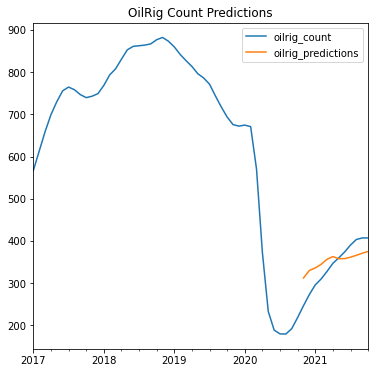

In [21]:
dfoil.loc['2017':]['oilrig_count'].plot(legend=True,title='OilRig Count Predictions')
testoil_predictions['oilrig_predictions'].plot(legend=True)

#### Save Model

In [22]:
# from tensorflow.keras.models import load_model
# model_oil.save('RNN OilRigCount_Version1')